In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('MNIST/data', one_hot=True)

Extracting MNIST/data\train-images-idx3-ubyte.gz
Extracting MNIST/data\train-labels-idx1-ubyte.gz
Extracting MNIST/data\t10k-images-idx3-ubyte.gz
Extracting MNIST/data\t10k-labels-idx1-ubyte.gz


In [4]:
(train_data, validation_data, test_data) = (mnist.train, mnist.validation, mnist.test)

In [5]:
train_data.num_examples

55000

In [6]:
with tf.name_scope('Inputs') as scope:
    x = tf.placeholder(shape=[None, 784], dtype=tf.float32, name='images')
    #x = tf.constant(train_data.images[:5], name='images')
    x_image = tf.reshape(x, [-1, 28, 28, 1], name='2d_images')
    y_correct = tf.placeholder(shape=[None, 10], dtype=tf.float32, name='correct_output')
    #y_correct = tf.constant(train_data.labels[:5], name='labels')

In [7]:
#sess = tf.Session()

In [8]:
#sess.run(tf.shape(x_image))

In [9]:
# first convolution
filter_conv1 = 32
with tf.name_scope('First_convolution') as scope:
    W_conv1 = tf.Variable(tf.truncated_normal(shape=[6, 6, 1, filter_conv1], stddev=0.1))
    b_conv1 = tf.Variable(tf.zeros([filter_conv1]))
    h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 2, 2, 1], padding='SAME') + b_conv1   # (None, 14, 14, filter_conv1)
    #h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1   # (None, 28, 28, filter_conv1)
    h_conv1_relu = tf.nn.relu(h_conv1)

In [10]:
#sess.run(tf.shape(h_conv1))

In [11]:
with tf.name_scope('First_pooling') as scope:
    h_pool_1 = tf.nn.max_pool(h_conv1_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 7, 7, filter_conv1)
    #h_pool_1 = tf.nn.max_pool(h_conv1_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 14, 14, filter_conv1)

In [12]:
#sess.run(tf.shape(h_pool_1))

In [13]:
# second convolution
filter_conv2 = 64
with tf.name_scope('Second_convolution') as scope:
    W_conv2 = tf.Variable(tf.truncated_normal(shape=[4, 4, filter_conv1, filter_conv2], stddev=0.1))
    b_conv2 = tf.Variable(tf.zeros([filter_conv2]))
    h_conv2 = tf.nn.conv2d(h_pool_1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2   # (None, 7, 7, filter_conv2)
    #h_conv2 = tf.nn.conv2d(h_pool_1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2   # (None, 14, 14, filter_conv2)
    h_conv2_relu = tf.nn.relu(h_conv2)

In [14]:
# second convolution
with tf.name_scope('Second_pooling') as scope:
    h_pool_2 = tf.nn.max_pool(h_conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 4, 4, filter_conv2)
    #h_pool_2 = tf.nn.max_pool(h_conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 7, 7, filter_conv2)

In [15]:
#sess.run(tf.shape(h_pool_2))

In [16]:
#sess.run(tf.shape(fc_input))

In [17]:
# Fully Connected
neuron_1 = 4*4*filter_conv2
#neuron_1 = 7*7*filter_conv2
neuron_2 = neuron_1 // 2

In [18]:
# flatten
fc_input = tf.reshape(h_pool_2, [-1, neuron_1])
#fc_input = tf.reshape(h_pool_2, [-1, 7*7*filter_conv2])

In [19]:
with tf.name_scope('First_hidden') as scope:
    W_1 = tf.Variable(tf.truncated_normal([neuron_1, neuron_2]))
    b_1 = tf.Variable(0.0, [neuron_2])
    a_1 = tf.nn.relu(tf.matmul(fc_input, W_1) + b_1)

In [20]:
keep_prob = tf.placeholder(tf.float32)
a_1_drop = tf.nn.dropout(a_1, keep_prob)

In [21]:
with tf.name_scope('Second_hidden') as scope:
    W_2 = tf.Variable(tf.truncated_normal([neuron_2, 10]))
    b_2 = tf.Variable(0.0, [10])
    y = tf.matmul(a_1_drop, W_2) + b_2

In [22]:
#sess.run(tf.shape(y))

In [23]:
with tf.name_scope('Cost') as scope:
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_correct, logits=y))

In [24]:
# Optimization
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluate model
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_correct,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
file_writer = tf.summary.FileWriter("CNN_baitap_1a", sess.graph)
# create a summary for our cost and accuracy
tf.summary.scalar("cost_summary", cross_entropy)
tf.summary.scalar("accuracy", accuracy)
# merge all summaries into a single operation which we can execute in a session 
summary_step = tf.summary.merge_all()
validation_size = 4000
for i in range(10001):
    batch_xs, batch_ys = mnist.train.next_batch(200)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch_xs, y_correct: batch_ys , keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        valid_xs, valid_ys = mnist.validation.next_batch(validation_size)
        print("Accuracy validation: {}".format(accuracy.eval(
                feed_dict = {x: valid_xs, y_correct: valid_ys, keep_prob: 1.0 })))
    _, summary = sess.run([train_step, summary_step], 
            feed_dict={x: batch_xs, y_correct: batch_ys, keep_prob: 0.6})
    # logging
    file_writer.add_summary(summary, i)

print("Accuracy: {}".format(accuracy.eval(feed_dict = {x: mnist.test.images[:validation_size], 
                                               y_correct: mnist.test.labels[:validation_size], keep_prob: 1.0})))
print("Saving model")
saved_W_conv1 = sess.run(W_conv1)
saved_b_conv1 = sess.run(b_conv1)
saved_W_conv2 = sess.run(W_conv2)
saved_b_conv2 = sess.run(b_conv2)

step 0, training accuracy 0.12
Accuracy validation: 0.11474999785423279
step 1000, training accuracy 0.785
Accuracy validation: 0.8375000953674316
step 2000, training accuracy 0.825
Accuracy validation: 0.835250198841095
step 3000, training accuracy 0.88
Accuracy validation: 0.8720000386238098
step 4000, training accuracy 0.875
Accuracy validation: 0.9065000414848328
step 5000, training accuracy 0.915
Accuracy validation: 0.9282500743865967
step 6000, training accuracy 0.9
Accuracy validation: 0.9417501091957092
step 7000, training accuracy 0.975
Accuracy validation: 0.9500001072883606
step 8000, training accuracy 0.94
Accuracy validation: 0.9615000486373901
step 9000, training accuracy 0.97
Accuracy validation: 0.9622499942779541
step 10000, training accuracy 0.97
Accuracy validation: 0.9672501087188721
Accuracy: 0.9552500247955322
Saving model


## Visualize first convolution and first pooling

Cách thủ công. Nên viết thành hàm plot qua matplotlib đàng hoàng.

<img src="../../images/TensorFlow_Digit_Classification_with_CNN_Guide/filter_examples.png" />

In [26]:
first_image = train_data.images[0].reshape((1, 28, 28, 1))

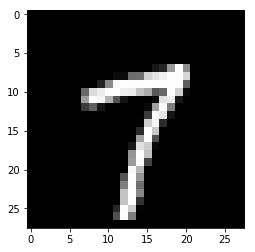

In [27]:
train_data.labels[0]
plt.imshow(first_image.reshape((28, 28)), cmap='gray')
plt.show()

In [28]:
saved_W_conv1.shape

(6, 6, 1, 32)

In [29]:
first_image_conv1 = tf.nn.relu(tf.nn.conv2d(first_image, saved_W_conv1, strides=[1, 2, 2, 1], padding='SAME') + saved_b_conv1)

In [30]:
sess.run(tf.shape(first_image_conv1))

array([ 1, 14, 14, 32])

In [31]:
first_feature_map_conv1 = tf.reshape(first_image_conv1[:, :, :, 0], (14, 14))
mid_feature_map_conv1 = tf.reshape(first_image_conv1[:, :, :, 15], (14, 14))
last_feature_map_conv1 = tf.reshape(first_image_conv1[:, :, :, 31], (14, 14))
#first_feature_map = tf.reshape(first_image_conv1[:, :, :, 0], (28, 28))

In [32]:
first_feature_map_arr_conv1 = sess.run(first_feature_map_conv1)
mid_feature_map_arr_conv1 = sess.run(mid_feature_map_conv1)
last_feature_map_arr_conv1 = sess.run(last_feature_map_conv1)

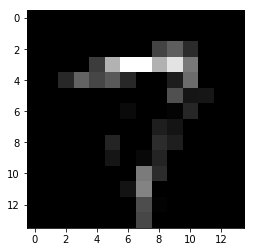

In [33]:
plt.imshow(first_feature_map_arr_conv1, cmap='gray')
plt.show()

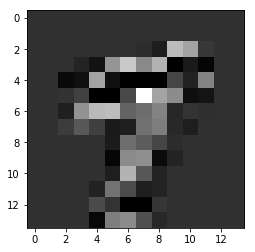

In [34]:
plt.imshow(mid_feature_map_arr_conv1, cmap='gray')
plt.show()

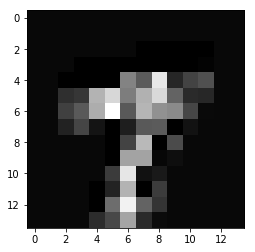

In [35]:
plt.imshow(last_feature_map_arr_conv1, cmap='gray')
plt.show()

In [36]:
first_image_pool1 = tf.nn.max_pool(first_image_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [37]:
sess.run(tf.shape(first_image_pool1))

array([ 1,  7,  7, 32])

In [38]:
first_feature_map_pool1 = tf.reshape(first_image_pool1[:, :, :, 0], (7, 7))
mid_feature_map_pool1 = tf.reshape(first_image_pool1[:, :, :, 15], (7, 7))
last_feature_map_pool1 = tf.reshape(first_image_pool1[:, :, :, 31], (7, 7))

In [39]:
first_feature_map_arr_pool1 = sess.run(first_feature_map_pool1)
mid_feature_map_arr_pool1 = sess.run(mid_feature_map_pool1)
last_feature_map_arr_pool1 = sess.run(last_feature_map_pool1)

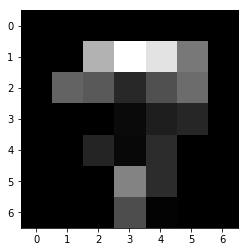

In [40]:
plt.imshow(first_feature_map_arr_pool1, cmap='gray')
plt.show()

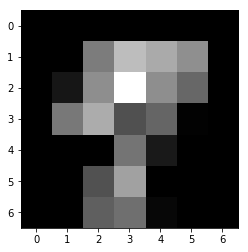

In [41]:
plt.imshow(mid_feature_map_arr_pool1, cmap='gray')
plt.show()

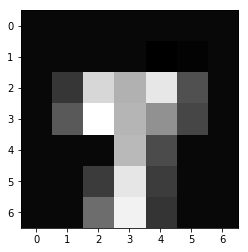

In [42]:
plt.imshow(last_feature_map_arr_pool1, cmap='gray')
plt.show()